# Lesson 1: All data is same. Only it's few properties get changed.

We will be performing sentiment analysis by treating the problem statement as a classification problem.

Tasks performed-
- Process text, turn into feature vectors
- Build a classifier
- Interpret the result from the analysis
- Try different classifiers
- Use textblob for sentiment analysis

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [142]:
from nltk.tokenize import TreebankWordTokenizer, RegexpTokenizer
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.corpora.dictionary import Dictionary

In [210]:
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.metrics import f1_score, precision_score, recall_score
import re

In [145]:
#TreebankWordTokenizer()
tokenize = RegexpTokenizer(r'\w+')
stops= stopwords.words('english')

In [146]:
pos_soup = BeautifulSoup(open('electronics/positive.review'), "lxml")

All reviews are within review_text tags. Example:

< review_text >
I purchased this unit due to frequent blackouts in my area and 2 power supplies going bad.  It will run my cable modem, router, PC, and LCD monitor for 5 minutes.  This is more than enough time to save work and shut down.   Equally important, I know that my electronics are receiving clean power.

I feel that this investment is minor compared to the loss of valuable data or the failure of equipment due to a power spike or an irregular power supply.

As always, Amazon had it to me in &lt;2 business days
< /review_text >

In [147]:
pos_rev = pos_soup.find_all("review_text")
len(pos_rev)

1000

In [148]:
neg_soup = BeautifulSoup(open('electronics/negative.review'), "lxml")
neg_rev = neg_soup.find_all("review_text")
len(neg_rev)

1000

We have 1000 positive and 1000 negative reviews.

In [149]:
def review_tokenizer(rev):
    rev_tok=tokenize.tokenize(rev)
    lemm = WordNetLemmatizer()
    rev_stops = [word.lower() for word in rev_tok if word.lower() not in stops]
    rev_lem = [lemm.lemmatize(word) for word in rev_stops]
    rev_nodig = [word for word in rev_lem if not word.isdigit() and len(word)>=2]
    rev_stops = [word.lower() for word in rev_nodig if word.lower() not in stops]
    return rev_stops


In [150]:
pos_clean_rev=[review_tokenizer(rev.get_text()) for rev in pos_rev]
neg_clean_rev=[review_tokenizer(rev.get_text()) for rev in neg_rev]

In [151]:
wc = WordCloud(width=800, height=600, stopwords=stops, background_color='white')

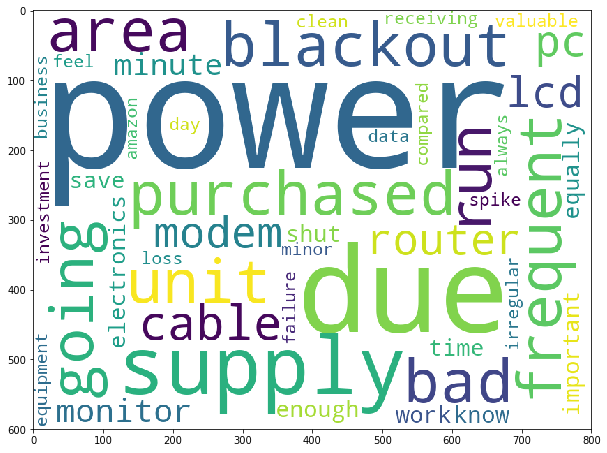

In [152]:
plt.figure(figsize=(10,8))
plt.imshow(wc.generate(' '.join(pos_clean_rev[0])))

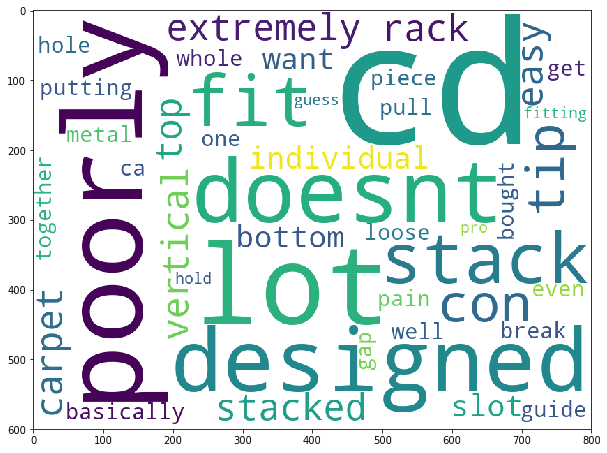

In [153]:
plt.figure(figsize=(10,8))
plt.imshow(wc.generate(' '.join(neg_clean_rev[0])))

We will create a word index map. Anytime we encounter a new word we will add it to the dictionary as key. It's value will be it's index.

It is quite similar to id2word function of LDA. But we won't be using it here so we are writing our own for loop. We won't be using Bag of Words as well as it will count the number of times a word appears in a doc in the corpus but not total times the word appears in the corpus. 

In [154]:
def index_map(token_reviews, current_count):
    for tokens in token_reviews:
        for token in tokens:
            if token not in word_index_map:
                word_index_map[token]=current_count
                current_count+=1
    return current_count

In [155]:
word_index_map={}
current_count=0

In [156]:
# updates word_index_map
current_count=index_map(pos_clean_rev, current_count)
current_count=index_map(neg_clean_rev, current_count)

In [157]:
print("There are", current_count, "unique words in our review data")

There are 9898 unique words in our review data


In [158]:
# checking first 5 wnique words.
c=0
for k in word_index_map:
    if c<5:
        print(k, word_index_map[k])
        c=c+1

purchased 0
unit 1
due 2
frequent 3
blackout 4


#### We will create a vector for all the words in the positive and negative cleaned tokenized list and also in word map. We will add the label at the end of this vector. 

1- positive, 0- negative

In [159]:
def tokens_to_vectors(tokens, label):
    x = np.zeros(len(word_index_map)+1)  # +1 for label
    for token in tokens:
        x[word_index_map[token]]+=1  # for each word make x[i]=1
    x=x/x.sum()  # normalize data
    x[-1] = label
    return x
        

In [160]:
pos_vectors = [tokens_to_vectors(tokens, 1) for tokens in pos_clean_rev]
pos_vectors[0][:5]

array([0.02040816, 0.02040816, 0.04081633, 0.02040816, 0.02040816])

In [161]:
N= len(pos_clean_rev)+len(neg_clean_rev)
Data= np.zeros((N, len(word_index_map)+1))

In [162]:
i=0

for tokens in pos_clean_rev:
    pos_vectors = tokens_to_vectors(tokens, 1)
    Data[i][:]=pos_vectors
    i=i+1

for tokens in neg_clean_rev:
    neg_vectors = tokens_to_vectors(tokens, 0)
    Data[i][:]=neg_vectors
    i=i+1

print(len(Data))

2000


In [163]:
np.random.shuffle(Data)

In [164]:
Data[0,-1] # labels

1.0

In [165]:
Data[0, :-1] # data other than labels

array([0., 0., 0., ..., 0., 0., 0.])

In [166]:
X=Data[:, :-1]
y=Data[:,-1]

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [168]:
lr_clf = LogisticRegression(solver='lbfgs')

In [169]:
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [170]:
#lr_clf.predict(X_test)
lr_clf.score(X_test, y_test)

0.73

In [171]:
print(len(lr_clf.coef_[0]))
print(lr_clf.coef_)
maxx = [max(m) for m in lr_clf.coef_]
minn = [min(m) for m in lr_clf.coef_]
print("max:", maxx)
print("min:", minn)

9898
[[-0.20526459 -0.69216085 -0.13727421 ... -0.01427285 -0.01427285
  -0.00808742]]
max: [2.902200846061914]
min: [-1.2206341165645112]


In [172]:
thr = 0.7

#### In logistic_regression coefficients if everything is a very similar magnitude, a larger pos/neg coefficient means larger effect, all things being equal.
https://stackoverflow.com/a/52172581/5148895

Here we will look for larger pos/neg coeffs to get what words lead to the sentiment. we will keep threshold at 0.7 for the 9898 records as for 0.8 we only got 14 words.

In [173]:
for k, v in word_index_map.items():
    if lr_clf.coef_[0][v]>thr or lr_clf.coef_[0][v]<-1*thr:
        print(k," ".ljust(10), str(lr_clf.coef_[0][v]))

back            -1.2206341165645112
good            1.4415161298312886
sound            0.7319698803196609
easy            0.8188037792398638
get            -0.7734465444458561
use            1.2075541301762243
quality            0.8647298590411647
item            -0.8898647562517669
price            1.8197003944873282
great            2.902200846061914
buy            -0.7857939823800965
support            -0.7683650720549822
excellent            0.9366124444693674
thing            -0.7724960345254207
return            -0.8426420672928648
waste            -0.7355366291914717


#### Correct Positives:
- good            1.2621520095492142
- easy            1.0687974334961972
- well            0.9069844083109375
- perfect            0.8078705304196796
- price            1.9825223794543463
- great            2.9578493962700074
- best            0.778444187589209
- highly            0.7562011913461636
- excellent            0.8428832978840244
- love            0.7444239500146951

#### Correct Negatives:

- back            -1.2144315316600418
- return            -0.9323457353483761
- waste            -0.7266815691066832

Looks like model was able to identify more positives than negatives.

#### We will try different models for this and increase our dataset from one category to multiple categories

Keeping Logistic regressions performance as base, we will try RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, GaussianNB, MultinomialNB algoes and see if the performance get's better.

In [174]:
rf_clf = RandomForestClassifier(n_estimators=20)
rf_clf.fit(X_train, y_train)
predict_rf = rf_clf.predict(X_test)

In [175]:
ada_clf = AdaBoostClassifier(n_estimators=30)
ada_clf.fit(X_train, y_train)
predict_ada = ada_clf.predict(X_test)

In [176]:
grd_clf = GradientBoostingClassifier(learning_rate=0.3)
grd_clf.fit(X_train, y_train)
predict_grd = grd_clf.predict(X_test)

In [177]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)
predict_gnb = gnb_clf.predict(X_test)

In [178]:
mnb_clf = MultinomialNB(alpha=0.01)
mnb_clf.fit(X_train, y_train)
predict_mnb = mnb_clf.predict(X_test)

In [179]:
print("Score for Random forest")
print("Score", rf_clf.score(X_test, y_test))
print('f1 score', f1_score(y_test, predict_rf))
print('recall_score', recall_score(y_test, predict_rf))
print('precision_score', precision_score(y_test, predict_rf))

Score for Random forest
Score 0.735
f1 score 0.7244367417677644
recall_score 0.718213058419244
precision_score 0.7307692307692307


In [180]:
print("Score for AdaBoost")
print("Score", ada_clf.score(X_test, y_test))
print('f1 score', f1_score(y_test, predict_ada))
print('recall_score', recall_score(y_test, predict_ada))
print('precision_score', precision_score(y_test, predict_ada))

Score for AdaBoost
Score 0.72
f1 score 0.731629392971246
recall_score 0.7869415807560137
precision_score 0.6835820895522388


In [181]:
print("Score for GradientBoosting")
print("Score", grd_clf.score(X_test, y_test))
print('f1 score', f1_score(y_test, predict_grd))
print('recall_score', recall_score(y_test, predict_grd))
print('precision_score', precision_score(y_test, predict_grd))

Score for GradientBoosting
Score 0.785
f1 score 0.7756521739130434
recall_score 0.7663230240549829
precision_score 0.7852112676056338


In [182]:
print("Score for GaussianNaiveBayes")
print("Score", gnb_clf.score(X_test, y_test))
print('f1 score', f1_score(y_test, predict_gnb))
print('recall_score', recall_score(y_test, predict_gnb))
print('precision_score', precision_score(y_test, predict_gnb))

Score for GaussianNaiveBayes
Score 0.6516666666666666
f1 score 0.6206896551724138
recall_score 0.5876288659793815
precision_score 0.6576923076923077


In [183]:
print("Score for MultinomialNaiveBayes")
print("Score", mnb_clf.score(X_test, y_test))
print('f1 score', f1_score(y_test, predict_mnb))
print('recall_score', recall_score(y_test, predict_mnb))
print('precision_score', precision_score(y_test, predict_mnb))

Score for MultinomialNaiveBayes
Score 0.775
f1 score 0.7746243739565944
recall_score 0.7972508591065293
precision_score 0.7532467532467533


#### Looks like just with little bit of hyper parameter tuning Multinomial Naive Bayes is the best performing Model for sentiment analysis.

## Analysis of words which result in positive or negative sentiments

Here for this analysis we took tokens from positive reviews and tagged them positive and tokens from negative reviews are tagged negative. It is visible from above result that sentiment analysis cannot be done just on words in isolation with the whole sentence. Most of the sentiments tagged positive might be for negative and vice versa.

For example useless which is tagged positive is usually in reviews which are negative. There are higherchnace that the reviewer was making comparison with some other product while praising the product which was purchased.

We will count the pos and neg words in a review and then validate whether our model can tell.

In [186]:
sentiments=list()

for rev in pos_rev:
    text = rev.getText()
    opinion = TextBlob(text)
    #print(opinion.sentiment.polarity, opinion.sentiment.subjectivity)
    sentiments.append([opinion.raw, opinion.sentiment.polarity, opinion.sentiment.subjectivity])
pos_sentiment_Analysis_df = pd.DataFrame(sentiments, columns=["Text", "Polarity", "Subjectivity"])
sentiments.clear()

for rev in neg_rev:
    text = rev.getText()
    opinion = TextBlob(text)
    #print(opinion.sentiment.polarity, opinion.sentiment.subjectivity)
    sentiments.append([opinion.raw, opinion.sentiment.polarity, opinion.sentiment.subjectivity])
neg_sentiment_Analysis_df = pd.DataFrame(sentiments, columns=["Text", "Polarity", "Subjectivity"])

In [208]:
pos_sentiment_Analysis_df.head()

,Text,Polarity,Subjectivity
0,\nI purchased this unit due to frequent blacko...,-0.009596,0.473232
1,\nI ordered 3 APC Back-UPS ES 500s on the reco...,0.126429,0.518571
2,\nWish the unit had a separate online/offline ...,0.170238,0.487202
3,\nCheaper than thick CD cases and less prone t...,0.008333,0.385417
4,\nHi\n\nI brought 256 MB Kingston SD card from...,0.442000,0.526000


In [188]:
pos_sentiment_Analysis_df.describe()

,Polarity,Subjectivity
count,1000.000000,1000.000000
mean,0.244003,0.533713
std,0.197643,0.158071
min,-0.750000,0.000000
25%,0.125650,0.448710
50%,0.223077,0.528711
75%,0.350625,0.610928
max,1.000000,1.000000


In [189]:
neg_sentiment_Analysis_df.describe()

,Polarity,Subjectivity
count,1000.000000,1000.000000
mean,0.051946,0.473232
std,0.184179,0.164777
min,-1.000000,0.000000
25%,-0.044920,0.382718
50%,0.050694,0.478819
75%,0.150069,0.571151
max,0.700000,1.000000


We will print the sentiments of words in a sentence by coloring them **<span style="color:red">red</span>** for negative and **<span style="color:green">green</span>** for positive.

In [302]:
new_df_sent=pd.concat([pos_sentiment_Analysis_df, neg_sentiment_Analysis_df])
df_sent = new_df_sent.sample(frac=1).reset_index(drop=True)

for data in df_sent["Text"][:20]:
    analysis = TextBlob(data)
    #print(analysis)
    
    if analysis.sentiment.polarity >= 0.25:
        print('\33[1;32m'+analysis.raw)
        print("*"*50)
        
    elif analysis.sentiment.polarity <= -0.1:
        print('\33[1;31m'+analysis.raw)
        print("*"*50)


I bought this screen as a replacement for my 8ms 17" Hyundai L90D+(which is a great low-priced screen for gaming), which was the replacement for a Dell fp2100 (that I gave to my wife). Anyways, this is an excellent monitor with excellent color reproduction and response times (more than enough for my flight sims). Movies are beautiful and the rather weird resolution hasn't been a problem. The design is probably the neatest looking out there (subjective I realize). The ONLY gripe I have w/ this monitor is lack of swivel (sigh). Other than that I'm very pleased with everything about this screen

**************************************************

What a waste of money.  I wish someone had posted before the Dec. 22 posting (which was excellent) pointing out that this device doesn't work on an iPod "shuffle".  I spent more to ship this item than I did for the item itself, so I am also stuck with one.

Rats!!

**************************************************

I ordered the apple ipod shuf

In [303]:
pol_dict=dict()

for data in df_sent["Text"]:
    data=re.sub("\W+", " ", data)
    analysis = TextBlob(data)
    assessment = analysis.sentiment_assessments.assessments
    #print("\n\n", assessment)
    
    #print(analysis.words)
    for gh in assessment:
        gh = list(gh)
        gh[0]=re.sub('\W+', "",str(gh[0]))
        #print(dict(zip(gh[::4], gh[1::4])))
        pol_dict.update(dict(zip(gh[::4], gh[1::4])))

In [297]:
for data in df_sent["Text"][:10]:
    print()
    data=re.sub("\W+", " ", data)
    for w in data.split():
        
        if w in pol_dict:
            p=pol_dict[w]
            if p >= 0.25:
                print('\33[1;32m'+ w, end=" ")
            elif p <0.1:
                print('\33[1;31m'+ w, end=" ")
        else:
            print('\33[0;34m'+ w, end=" ")


I purchased this unit due to blackouts in my area and 2 power supplies going bad It will run my cable modem router PC and LCD monitor for 5 minutes This is more than enough time to save work and shut down Equally important I know that my electronics are receiving clean power I feel that this investment is minor compared to the loss of valuable data or the failure of equipment due to a power spike or an irregular power supply As always Amazon had it to me in 2 business days 
I ordered 3 APC Back UPS ES 500s on the recommendation of an employee of mine who used to work at APC I ve had them for about a month now without any problems They ve functioned properly through a few power interruptions I ll gladly order more if the need arises Pros Large plug spacing good for power adapters Simple design Long cord Cons No line conditioning usually an expensive option 
Wish the unit had a separate online offline light When power to the unit is missing the single red light turns off only when the w